In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
# a) Data Pre-processing
# Load the dataset
data = pd.read_csv('Mall_Customers.csv')

In [3]:
# Display basic info
print("Dataset Info:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

First 5 rows:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [4]:
# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [5]:
# Convert categorical data (Genre) to numerical
data['Genre'] = data['Genre'].map({'Male': 0, 'Female': 1})

# Feature selection - we'll focus on Annual Income and Spending Score for clustering
X = data[['Annual Income (k$)', 'Spending Score (1-100)']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# b) Data Preparation - Train-Test Split
# For clustering, we typically use all data, but for demonstration we'll do a split
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)



K-means Clustering:


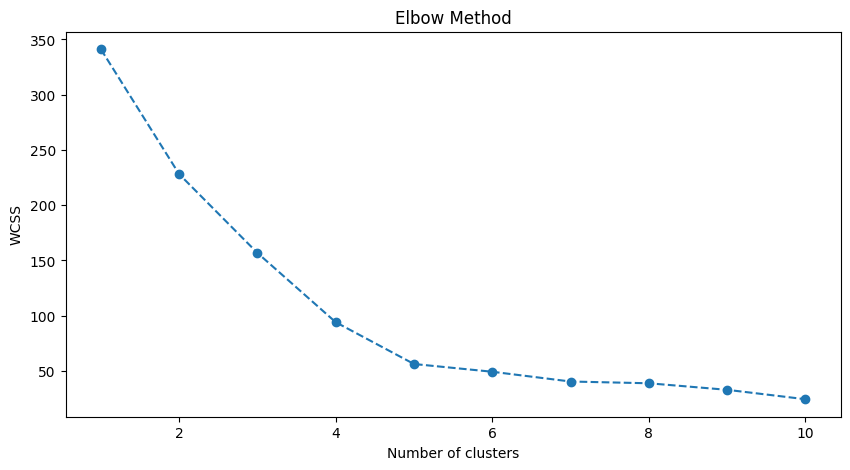

Silhouette Score for K-means: 0.57


In [6]:
# c) Apply Machine Learning Algorithms

# Algorithm 1: K-means Clustering
print("\nK-means Clustering:")

# Find optimal number of clusters using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Based on the elbow method, let's choose 5 clusters
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans.fit(X_train)
y_kmeans = kmeans.predict(X_test)

# Evaluate K-means
silhouette_avg = silhouette_score(X_test, y_kmeans)
print(f"Silhouette Score for K-means: {silhouette_avg:.2f}")

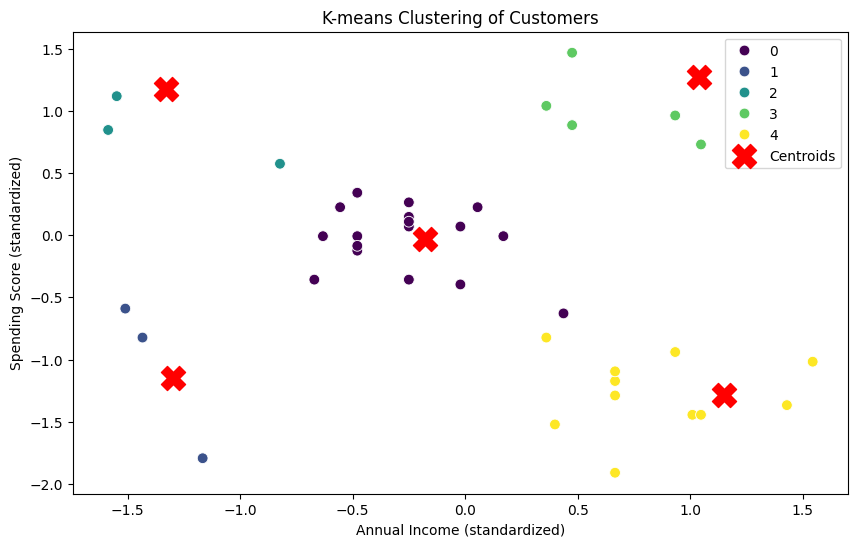

In [7]:
# Visualize K-means clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_kmeans, palette='viridis', s=60)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('K-means Clustering of Customers')
plt.xlabel('Annual Income (standardized)')
plt.ylabel('Spending Score (standardized)')
plt.legend()
plt.show()


In [8]:
# Algorithm 2: DBSCAN Clustering
print("\nDBSCAN Clustering:")

dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X_test)

# Count clusters (excluding noise if any)
n_clusters = len(set(y_dbscan)) - (1 if -1 in y_dbscan else 0)
n_noise = list(y_dbscan).count(-1)
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Evaluate DBSCAN (only if not all points are noise)
if n_clusters > 0:
    silhouette_avg = silhouette_score(X_test, y_dbscan)
    print(f"Silhouette Score for DBSCAN: {silhouette_avg:.2f}")


DBSCAN Clustering:
Estimated number of clusters: 2
Estimated number of noise points: 13
Silhouette Score for DBSCAN: 0.35


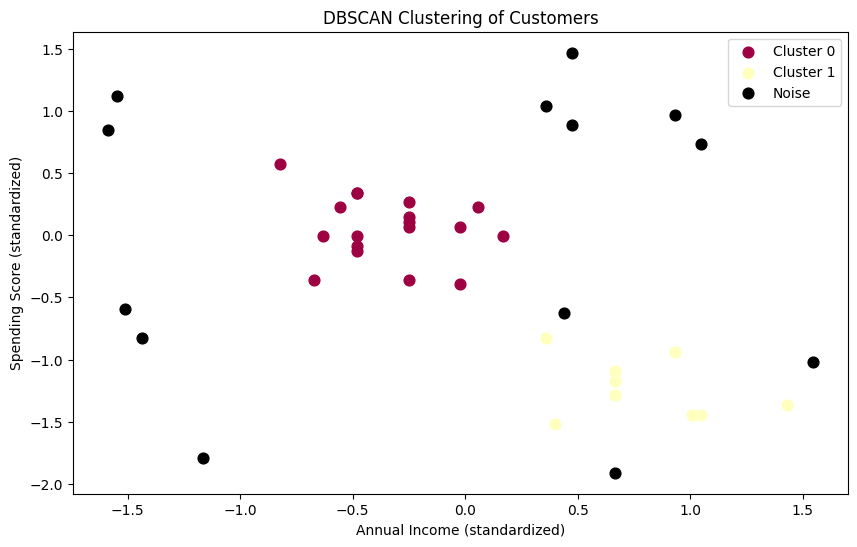

In [9]:
# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
unique_labels = set(y_dbscan)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise

    class_member_mask = (y_dbscan == k)
    xy = X_test[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], s=60, label=f'Cluster {k}' if k != -1 else 'Noise')

plt.title('DBSCAN Clustering of Customers')
plt.xlabel('Annual Income (standardized)')
plt.ylabel('Spending Score (standardized)')
plt.legend()
plt.show()

In [10]:
# Interpret the clusters (for K-means as it's more stable)
# Inverse transform to get original scale
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
print("\nCluster Centroids (Annual Income, Spending Score):")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}: {centroid[0]:.2f}k$, {centroid[1]:.2f} score")

# Identify profitable segments
# Assuming higher spending score is better, regardless of income
most_profitable_cluster = np.argmax(centroids[:, 1])
print(f"\nMost profitable customer segment: Cluster {most_profitable_cluster}")
print(f"Characteristics: Annual Income ~{centroids[most_profitable_cluster, 0]:.2f}k$, Spending Score ~{centroids[most_profitable_cluster, 1]:.2f}")

# Get customers in the most profitable cluster
full_data_scaled = scaler.fit_transform(X)
all_clusters = kmeans.predict(full_data_scaled)
profitable_customers = data[all_clusters == most_profitable_cluster]
print("\nSample of profitable customers:")
print(profitable_customers.head())


Cluster Centroids (Annual Income, Spending Score):
Cluster 0: 55.83k$, 49.40 score
Cluster 1: 26.55k$, 20.65 score
Cluster 2: 25.68k$, 80.53 score
Cluster 3: 87.82k$, 82.97 score
Cluster 4: 90.62k$, 17.00 score

Most profitable customer segment: Cluster 3
Characteristics: Annual Income ~87.82k$, Spending Score ~82.97

Sample of profitable customers:
     CustomerID  Genre  Age  Annual Income (k$)  Spending Score (1-100)
123         124      0   39                  69                      91
125         126      1   31                  70                      77
127         128      0   40                  71                      95
129         130      0   38                  71                      75
131         132      0   39                  71                      75
